<a href="https://colab.research.google.com/github/chaitu2568/DEEP-LEARNING/blob/master/Convolution_Neural_Networks_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip3 install torch torchvision

In [0]:
import torch 
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F

In [0]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
# Applying the transformations to the data
# 1->Numpy to Tensor(returns float values ranging from 0 to 1)
# 2->Normalising the values by setting mean=0.5 and sd=0.5 for ColorScale,Width and Height of Image (returns values ranging from (-1,1))

transforms=transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
# Datasets are taken from the MNIST dataset
train_data=datasets.MNIST(root='./imgdata',train=True,download=True,transform=transforms)
validation_data=datasets.MNIST(root='./imgdata',train=False,download=True,transform=transforms)
# laoding the datasets batch wise for each epoch
train_load=torch.utils.data.DataLoader(dataset=train_data,batch_size=100,shuffle=True) #to avoid the Local Minimum
validation_load=torch.utils.data.DataLoader(dataset=validation_data,batch_size=100,shuffle=False)

In [0]:
# Now to plot the graph covert back into Tensor

def img_convert(tensor):
#   first cloning and coverting into numpy array
  image=tensor.cpu().clone().detach().numpy()
#   changing dimensions from 1,28,28 to 28,28,1
  image=image.transpose(1,2,0)  
#   deNormalizing it by multiplying with sd and adding mean
  image=image*np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5))
#   changing the range from 0 to 1
  image=image.clip(0,1)
  return image

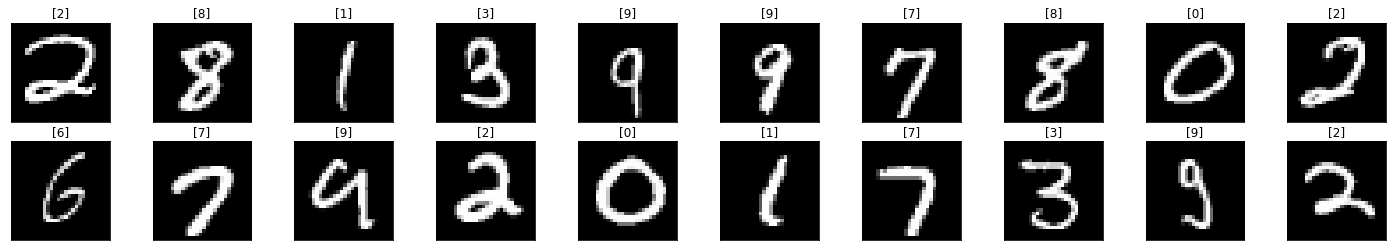

In [50]:

dataiter=iter(train_load)
images,labels = dataiter.next() #loads 100 batchsize of data for every iteration
main=plt.figure(figsize=(25,4))


for index in np.arange(20):
  ax=main.add_subplot(2,10,index+1,xticks=[], yticks=[])
  plt.imshow(img_convert(images[index]))
  ax.set_title([labels[index].item()])
  
  

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
#     Parameters to convolution layer
#       first-> No of Input Channels of the Images(Grey Scale Image Size = 1)
#         Second-> Depth of Filters (feature Maps)
#           Third-> Size of the Kernel Passed
#             four-> Strip Size (rate of movement at the time of convolutions)

    self.conv1=nn.Conv2d(1,20,5,1)
    self.conv2=nn.Conv2d(20,50,5,1)
    
#     28*28 in conv1 coverts to 24*24, it coverts to 12*12 in Pooling and Secod conv2 converts to 8*8, pooling coverts to 4*4
    self.fc1=nn.Linear(4*4*50,500)
    self.dropout1=nn.Dropout(0.5)
    self.fc2=nn.Linear(500,10)
    
  def forward(self,x):
    x=F.relu(self.conv1(x))
#     Paasing to Poooling Layer which reduces the half of the dimensions
    x=F.max_pool2d(x,2,2)
    x=F.relu(self.conv2(x))
    x=F.max_pool2d(x,2,2)
#     flattening the size before sending to FCN
    x=x.view(-1,4*4*50)
    x=F.relu(self.fc1(x))
    x=self.dropout1(x)
    x=self.fc2(x)
    return x
  
    

In [66]:
obj=LeNet().to(device)
obj


LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(obj.parameters(),lr=0.0001)

In [68]:
epochs=15

train_loss=[]
train_accuracy=[]
validation_loss=[]
validation_accuracy=[]
for ite in range(epochs):
  epoch_loss=0
  epoch_accuracy=0
  batch_loss=0
  batch_accuracy=0
  
#   validation constraints
  epoch_val_loss=0
  epoch_val_accuracy=0
  batch_val_accuracy=0
  batch_val_loss=0

  for images, labels in train_load:
    images=images.to(device)
    labels=labels.to(device)
#     images=images.view(images.shape[0],-1)
    results=obj(images)
    loss=criterion(results,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    batch_loss+=loss.item() 
    _,preds=torch.max(results,1)
    batch_accuracy+=torch.sum(preds==labels.data)
    
    
  else:
    for val_img, val_lab in validation_load:
      val_img=val_img.to(device)
      val_lab=val_lab.to(device)
#       val_img=val_img.view(val_img.shape[0],-1)
      val_results=obj(val_img)
      val_loss=criterion(val_results,val_lab)
      
      batch_val_loss+=val_loss.item() 
      _,val_preds=torch.max(val_results,1)
      batch_val_accuracy+=torch.sum(val_preds==val_lab.data)
    
      
      
    epoch_val_loss=batch_val_loss/len(validation_load)
    validation_loss.append(epoch_val_loss)
    epoch_val_accuracy=batch_val_accuracy.float()/len(validation_load)
    validation_accuracy.append(epoch_val_accuracy)
    
      
    epoch_loss=batch_loss/len(train_load)
    train_loss.append(epoch_loss)
    epoch_accuracy=batch_accuracy.float()/len(train_load)
    train_accuracy.append(epoch_accuracy)
    
    print('Present Epoch:',ite)
    print('Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(epoch_val_loss,epoch_val_accuracy.item()))
    print('Training Loss: {:.4f}, Training Accuracy: {:.4f}'.format(epoch_loss,epoch_accuracy.item()))
    

Present Epoch: 0
Validation Loss: 0.1643, Validation Accuracy: 95.3100
Training Loss: 0.5606, Training Accuracy: 85.3550
Present Epoch: 1
Validation Loss: 0.0977, Validation Accuracy: 97.1400
Training Loss: 0.1419, Training Accuracy: 95.7417
Present Epoch: 2
Validation Loss: 0.0736, Validation Accuracy: 97.6600
Training Loss: 0.0944, Training Accuracy: 97.2417
Present Epoch: 3
Validation Loss: 0.0603, Validation Accuracy: 98.0500
Training Loss: 0.0748, Training Accuracy: 97.7617
Present Epoch: 4
Validation Loss: 0.0516, Validation Accuracy: 98.3900
Training Loss: 0.0628, Training Accuracy: 98.1533
Present Epoch: 5
Validation Loss: 0.0472, Validation Accuracy: 98.4900
Training Loss: 0.0541, Training Accuracy: 98.3533
Present Epoch: 6
Validation Loss: 0.0406, Validation Accuracy: 98.6500
Training Loss: 0.0484, Training Accuracy: 98.5617
Present Epoch: 7
Validation Loss: 0.0405, Validation Accuracy: 98.7000
Training Loss: 0.0425, Training Accuracy: 98.7250
Present Epoch: 8
Validation Loss

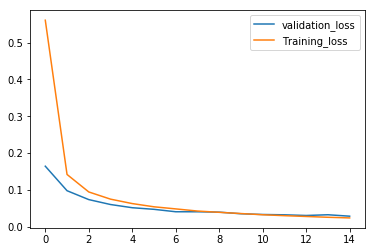

In [69]:
plt.plot(validation_loss,label='validation_loss')
plt.plot(train_loss,label='Training_loss')
plt.legend()

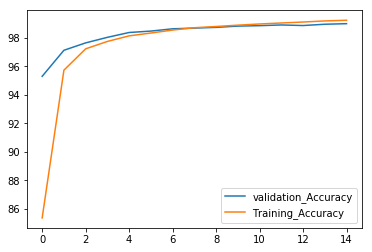

In [70]:
plt.plot(validation_accuracy,label='validation_Accuracy')
plt.plot(train_accuracy,label='Training_Accuracy')
plt.legend()

In [71]:
print(type(validation_load))

<class 'torch.utils.data.dataloader.DataLoader'>


In [0]:
import PIL.ImageOps

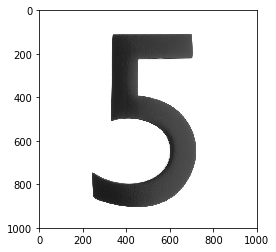

In [73]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

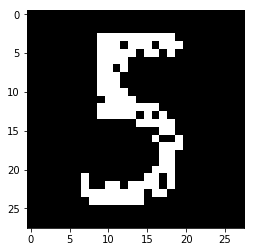

In [74]:
# data preprocessing 
# 1->Invert the colors of the image
img=PIL.ImageOps.invert(img)
# convert the image into binary color (0,1)
img=img.convert('1')
img=transforms(img)
plt.imshow(img_convert(img))


In [75]:
img=img.to(device)
img=img[0].unsqueeze(0).unsqueeze(0)
result=obj(img)
_,preds=torch.max(result,1)
print(preds.item())

5


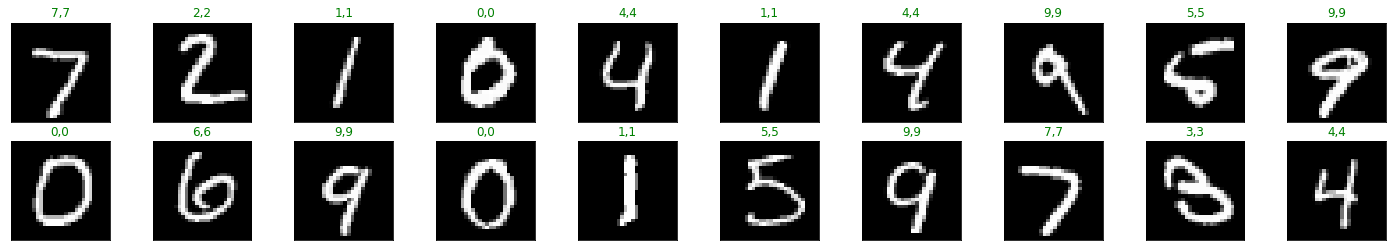

In [76]:
dataiter=iter(validation_load)
images,labels = dataiter.next() #loads 100 batchsize of data for every iteration
images=images.to(device)
labels=labels.to(device)
# images_=images.view(images.shape[0],-1)
results=obj(images)
_,predics=torch.max(results,1)
main=plt.figure(figsize=(25,4))
for index in np.arange(20):
  ax=main.add_subplot(2,10,index+1,xticks=[], yticks=[])
  plt.imshow(img_convert(images[index]))
  ax.set_title('{},{}'.format(str(predics[index].item()),str(labels[index].item())),color=('green'if predics[index]==labels[index] else 'red'))